In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import torch
import torchvision.transforms as T
from shutil import rmtree
from sklearn.model_selection import train_test_split
from tqdm.autonotebook import tqdm, trange
from torch.nn.functional import softmax
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
from torchvision.datasets import ImageFolder


from predictors.alexnet import Alexnet
from predictors.half_alexnet import HalfAlexnet

from datasets import CIFAR10, ProxyDataset

%matplotlib inline

In [3]:
LR = 0.001
EPOCHS = 200
BATCH_SIZE = 32
CONFIDENCE_TH = 0.8

DATASET_PATH = '.'

# Set random seed for replicating testing results
RANDOM_SEED = 0
np.random.seed(0)
torch.manual_seed(0)
if torch.cuda.is_available():
    torch.cuda.manual_seed(0)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [4]:
# Teacher
teacher_model = Alexnet(name=None, n_outputs=10)

ckpt_path = 'checkpoints/teacher_alexnet_for_cifar10_state_dict'
teacher_model.load_state_dict(torch.load(ckpt_path, map_location=device))
teacher_model.eval()
teacher_model = teacher_model.to(device)

In [5]:
# Define dataset
label_mapper = {
    'airplane': 0,
    'automobile': 1,
    'bird': 2,
    'cat': 3,
    'deer': 4,
    'dog': 5,
    'frog': 6,
    'horse': 7,
    'ship': 8,
    'truck': 9
}
label_mapper_inv = {v:k for k,v in label_mapper.items()}

# Get images paths and labels
images = []
labels = []

folders_path = os.path.join(DATASET_PATH,'images_generated')
for folder in os.listdir(folders_path):
    if 'imagenet' in folder:
      continue
    class_path = os.path.join(folders_path,folder)
    images_names = os.listdir(class_path)
    
    for image_name in images_names:
        images.append(os.path.join(class_path,image_name))
        labels.append(label_mapper[folder])

In [6]:
proxy_transforms = T.Compose([
    T.Resize((32,32)),
    T.Normalize((0.5,), (0.5,))
])

proxy_dataset = ProxyDataset(images, labels, proxy_transforms, True)
proxy_dataloader  = DataLoader(proxy_dataset,  batch_size=BATCH_SIZE)

# Obtain teacher predictions
filtered_images = []
filtered_labels = []
filtered_soft_labels = []

with torch.no_grad():
    for img,label,path,_ in tqdm(proxy_dataloader):
        img = img.to(device=device)
        label = label.to(device=device)

        logits = teacher_model(img)
        pred = softmax(logits, dim=1)
        
        confidence,y_hat = torch.max(pred, dim=1)

        filtered_images.extend(list(path))
        filtered_labels.extend(y_hat.tolist())
        filtered_soft_labels.extend(pred)
        
# Display results of filtering
print(f'A total of {len(filtered_images)} remained out of {len(proxy_dataset)}')
print()
counter_per_class = {v:0 for k,v in label_mapper.items()}
for label in filtered_labels:
    counter_per_class[label] += 1
for clasa in counter_per_class:
    print(f'Class {clasa}({label_mapper_inv[clasa]}) has {counter_per_class[clasa]} entries')

  0%|          | 0/1600 [00:00<?, ?it/s]

A total of 51200 remained out of 51200

Class 0(airplane) has 6384 entries
Class 1(automobile) has 5145 entries
Class 2(bird) has 4796 entries
Class 3(cat) has 5329 entries
Class 4(deer) has 5571 entries
Class 5(dog) has 4287 entries
Class 6(frog) has 4553 entries
Class 7(horse) has 5025 entries
Class 8(ship) has 5178 entries
Class 9(truck) has 4932 entries


In [7]:
# Define the student model
student_model = HalfAlexnet(name=None, n_outputs=10)

path_to_save = 'pretrained_student.pt'
if torch.cuda.is_available():
    student_model.load_state_dict(torch.load(path_to_save))
else:
    student_model.load_state_dict(torch.load(path_to_save, map_location ='cpu'))
student_model.to(device)

# Define optimizer
optimizer = torch.optim.Adam(student_model.parameters(), lr=LR)

# Define loss function
criterion = torch.nn.CrossEntropyLoss(reduction='mean')

In [8]:
try:
  # raise
  # Do a stratified split of the data
  NO_IMGS_TO_USE = 4096
  
  filtered_images_subset, filtered_images_unused, filtered_labels_subset, filtered_labels_unused, filtered_soft_labels_subset, filtered_soft_labels_unused = \
      train_test_split(filtered_images, filtered_labels, filtered_soft_labels, train_size=NO_IMGS_TO_USE, stratify=filtered_labels, random_state=RANDOM_SEED)  

  train_images, validation_images, train_labels, validation_labels, train_soft_labels, validation_soft_labels = \
      train_test_split(filtered_images_subset, filtered_labels_subset, filtered_soft_labels_subset, train_size=0.8, stratify=filtered_labels_subset, random_state=RANDOM_SEED)
  valid_images, test_images, valid_labels, test_labels, valid_soft_labels, test_soft_labels = \
      train_test_split(validation_images, validation_labels, validation_soft_labels, test_size=0.5, stratify=validation_labels, random_state=RANDOM_SEED)
except:
  # For small datasets 
  print('Small dataset')
  NO_IMGS_TO_USE = 30
  NO_TRAIN_IMGS = 10

  """ DEV - train_test_split fails, need to manually introduce 1 sample
  """
  for i in range(len(filtered_labels)-1,-1,-1):
    if filtered_labels[i] == 5:
      img_dev = filtered_images[i]
      soft_label_dev = filtered_soft_labels[i]
      break

  filtered_images_subset, filtered_images_unused, filtered_labels_subset, filtered_labels_unused, filtered_soft_labels_subset, filtered_soft_labels_unused = \
    train_test_split(filtered_images, filtered_labels, filtered_soft_labels, train_size=NO_IMGS_TO_USE, stratify=filtered_labels, random_state=RANDOM_SEED)  
  train_images, validation_images, train_labels, validation_labels, train_soft_labels, validation_soft_labels = \
    train_test_split(filtered_images_subset, filtered_labels_subset, filtered_soft_labels_subset, train_size=NO_TRAIN_IMGS, stratify=filtered_labels_subset, random_state=RANDOM_SEED)
  
  """ DEV - interchange an image
  """
  for i in range(len(validation_images)):
    if validation_labels[i] == 0:
      validation_images[i] = img_dev
      validation_labels[i] = 5
      validation_soft_labels[i] = soft_label_dev
      break

  valid_images, test_images, valid_labels, test_labels, valid_soft_labels, test_soft_labels = \
      train_test_split(validation_images, validation_labels, validation_soft_labels, test_size=0.5, stratify=validation_labels)

In [9]:
# Define the transformations
train_transforms = T.Compose([
    T.Resize((32,32)),
    T.RandomCrop(32, padding=4),
    T.RandomHorizontalFlip(p=0.5),
    T.Normalize((0.5,), (0.5,))
])
valid_transforms = T.Compose([
    T.Resize((32,32)),
    T.Normalize((0.5,), (0.5,))
])

# Define the proxy datasets
proxy_train_dataset = ProxyDataset(train_images, train_labels, train_transforms, False, train_soft_labels)
proxy_valid_dataset = ProxyDataset(valid_images, valid_labels, valid_transforms, False, valid_soft_labels)
proxy_test_dataset  = ProxyDataset(test_images,  test_labels,  valid_transforms, False, test_soft_labels)

# Define the proxy dataloaders
train_dataloader = DataLoader(proxy_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = DataLoader(proxy_valid_dataset, batch_size=BATCH_SIZE)
test_dataloader  = DataLoader(proxy_test_dataset,  batch_size=BATCH_SIZE)

# Define true dataset
true_dataset = CIFAR10(input_size = 32)

validate_on_trueds = True
if validate_on_trueds:
    true_valid_ds = true_dataset.test_dataloader()

Files already downloaded and verified
Files already downloaded and verified


In [10]:
# Class for early stopping
class EarlyStopping():
    def __init__(self, tolerance=5, min_delta=0):

        self.tolerance = tolerance
        self.min_delta = min_delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def __call__(self, validation_loss):
        if self.best_score is None:
          self.best_score = validation_loss
        elif validation_loss - self.best_score < self.min_delta:
          self.best_score = validation_loss
        else:
          self.counter +=1
          if self.counter >= self.tolerance:  
              self.early_stop = True

In [11]:
early_stopping = EarlyStopping(tolerance=20, min_delta=0.001)
# early_stopping = EarlyStopping(tolerance=5, min_delta=0.001)

# Training the student
for epoch in range(EPOCHS):
    # Define progress bar
    loop = tqdm(enumerate(train_dataloader), total=len(train_dataloader))
    
    # Training loop
    student_model.train()
    training_loss_epoch = []
    for batch_idx, (x,y,soft_y) in loop:
        optimizer.zero_grad()
        
        x = x.to(device=device)
        y = y.to(device=device)
        soft_y = soft_y.to(device=device)
        
        # Forward pass
        logits = student_model(x)
        # Backward pass
        loss = criterion(input=logits, target=soft_y)
        training_loss_epoch.append(loss.item())
        # Prob trb inlocuit criterionul, sa adaugi soft-labels
        loss.backward()
        
        # Optimize
        optimizer.step()
        
        # Update progress bar
        loop.set_description(f'Epoch {epoch+1}/{EPOCHS}')
        loop.set_postfix(training_loss=loss.item())
    
    # Validation loop on proxy validation dataset
    student_model.eval()
    validation_loss_epoch = []  
    acc = 0
    with torch.no_grad():
        for x,y,_ in valid_dataloader:
            x = x.to(device=device)
            y = y.to(device=device)
        
            logits = student_model(x)
            pred = softmax(logits, dim=1)
            
            confidence,y_hat = torch.max(pred, dim=1)
            
            loss = criterion(input=logits, target=y)
            validation_loss_epoch.append(loss.item())
            
            acc += torch.sum(y_hat==y).item()
        
    loop.write(f'validation_loss on proxy = {sum(validation_loss_epoch)/len(validation_loss_epoch):.4f}')
    loop.write(f'validation_accuracy on proxy = {100*acc/len(proxy_valid_dataset):.2f}%')

    if validate_on_trueds:
        # Validation loop on proxy validation dataset
        student_model.eval()
        with torch.no_grad():
            val_loss = []
            acc = 0
            for x,y in true_valid_ds:
                x = x.to(device=device)
                y = y.to(device=device)
            
                logits = student_model(x)
                pred = softmax(logits, dim=1)
                
                confidence,y_hat = torch.max(pred, dim=1)
                
                loss = criterion(input=logits, target=y)
                val_loss.append(loss.item())
                
                acc += torch.sum(y_hat==y).item()
            
        loop.write(f'validation_loss on true ds = {sum(val_loss)/len(val_loss):.4f}')
        loop.write(f'validation_accuracy on true ds = {100*acc/len(true_dataset.test_dataset):.2f}%')

    early_stopping(sum(validation_loss_epoch)/len(validation_loss_epoch))
    if early_stopping.early_stop:
      print(f"We are at epoch {epoch}")
      break

  0%|          | 0/103 [00:00<?, ?it/s]

validation_loss on proxy = 0.9834
validation_accuracy on proxy = 71.46%
validation_loss on true ds = 1.6351
validation_accuracy on true ds = 40.28%


  0%|          | 0/103 [00:00<?, ?it/s]

validation_loss on proxy = 0.7034
validation_accuracy on proxy = 77.32%
validation_loss on true ds = 1.4906
validation_accuracy on true ds = 45.55%


  0%|          | 0/103 [00:00<?, ?it/s]

validation_loss on proxy = 0.6513
validation_accuracy on proxy = 80.24%
validation_loss on true ds = 1.5728
validation_accuracy on true ds = 44.90%


  0%|          | 0/103 [00:00<?, ?it/s]

validation_loss on proxy = 0.6198
validation_accuracy on proxy = 81.95%
validation_loss on true ds = 1.4617
validation_accuracy on true ds = 49.10%


  0%|          | 0/103 [00:00<?, ?it/s]

validation_loss on proxy = 0.5811
validation_accuracy on proxy = 83.66%
validation_loss on true ds = 1.6199
validation_accuracy on true ds = 47.50%


  0%|          | 0/103 [00:00<?, ?it/s]

validation_loss on proxy = 0.5722
validation_accuracy on proxy = 83.90%
validation_loss on true ds = 1.5034
validation_accuracy on true ds = 49.86%


  0%|          | 0/103 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [12]:
# Testing on CIFAR10 ground truth
true_dataloader = true_dataset.test_dataloader()
acc_per_class = {k:[0,0,0] for k,v in label_mapper_inv.items()}

student_model.eval()
student_model.return_feature_domain = False
with torch.no_grad():
    test_loss = []
    acc = 0
    for x,y in true_dataloader:
        x = x.to(device=device)
        y = y.to(device=device)
    
        logits = student_model(x)
        pred = softmax(logits, dim=1)
        
        confidence,y_hat = torch.max(pred, dim=1)
        
        loss = criterion(input=logits, target=y)
        test_loss.append(loss.item())
        
        acc += torch.sum(y_hat==y)
        
        for i in range(len(y)):
            a = y[i].item()
            p = y_hat[i].item()
            
            
            if a == p:
                acc_per_class[a][0] += 1 # correct predictions
            acc_per_class[a][1] += 1     # total number 
            acc_per_class[p][2] += 1     # predictions of class
        
    print('Student with true dataset:')
    print(f'test_loss = {sum(test_loss)/len(test_loss):.4f}')                  # 1.7439;  1.6199
    print(f'test_accuracy = {100*acc/len(true_dataset.test_dataset):.2f}%')    # 46.09%;  48.57%
    print()
    
for k,v in acc_per_class.items():
    print(f'Class {label_mapper_inv[k]}: correct_pred={v[0]}, actual={v[1]} => acc={v[0]*100/v[1]:.2f}%, total_pred={v[2]}')

Student with true dataset:
test_loss = 1.4548
test_accuracy = 51.73%

Class airplane: correct_pred=395, actual=1000 => acc=39.50%, total_pred=559
Class automobile: correct_pred=586, actual=1000 => acc=58.60%, total_pred=797
Class bird: correct_pred=496, actual=1000 => acc=49.60%, total_pred=1197
Class cat: correct_pred=609, actual=1000 => acc=60.90%, total_pred=2060
Class deer: correct_pred=484, actual=1000 => acc=48.40%, total_pred=874
Class dog: correct_pred=599, actual=1000 => acc=59.90%, total_pred=1465
Class frog: correct_pred=163, actual=1000 => acc=16.30%, total_pred=197
Class horse: correct_pred=541, actual=1000 => acc=54.10%, total_pred=889
Class ship: correct_pred=516, actual=1000 => acc=51.60%, total_pred=657
Class truck: correct_pred=784, actual=1000 => acc=78.40%, total_pred=1305


In [ ]:
# Testing using labels predicted with teacher
true_dataloader = true_dataset.test_dataloader()
acc_per_class = {k:[0,0,0] for k,v in label_mapper_inv.items()}

student_model.eval()
teacher_model.eval()
with torch.no_grad():
    test_loss = []
    acc = 0
    for x,y in true_dataloader:
        x = x.to(device=device)
        # y = y.to(device=device)

        teacher_pred = softmax(teacher_model(x), dim=1)
        _, y = torch.max(teacher_pred, dim=1)
    
        logits = student_model(x)
        pred = softmax(logits, dim=1)
        
        confidence,y_hat = torch.max(pred, dim=1)
        
        loss = criterion(input=logits, target=y)
        test_loss.append(loss.item())
        
        acc += torch.sum(y_hat==y)
        
        for i in range(len(y)):
            a = y[i].item()
            p = y_hat[i].item()
            
            
            if a == p:
                acc_per_class[a][0] += 1
            acc_per_class[a][1] += 1
            acc_per_class[p][2] += 1
        
    print('Student with true dataset:')
    print(f'test_loss = {sum(test_loss)/len(test_loss):.4f}')                  # 1.7439;  1.6199
    print(f'test_accuracy = {100*acc/len(true_dataset.test_dataset):.2f}%')    # 46.09%;  48.57%
    print()
    
for k,v in acc_per_class.items():
    print(f'Class {label_mapper_inv[k]}: correct_pred={v[0]}, actual={v[1]} => acc={v[0]*100/v[1]:.2f}%, total_pred={v[2]}')

Student with true dataset:
test_loss = 1.4893
test_accuracy = 52.48%

Class airplane: correct_pred=569, actual=1038 => acc=54.82%, total_pred=886
Class automobile: correct_pred=606, actual=1002 => acc=60.48%, total_pred=779
Class bird: correct_pred=449, actual=965 => acc=46.53%, total_pred=1085
Class cat: correct_pred=679, actual=938 => acc=72.39%, total_pred=2427
Class deer: correct_pred=472, actual=1108 => acc=42.60%, total_pred=805
Class dog: correct_pred=425, actual=913 => acc=46.55%, total_pred=1077
Class frog: correct_pred=334, actual=996 => acc=33.53%, total_pred=442
Class horse: correct_pred=397, actual=1063 => acc=37.35%, total_pred=529
Class ship: correct_pred=587, actual=939 => acc=62.51%, total_pred=901
Class truck: correct_pred=730, actual=1038 => acc=70.33%, total_pred=1069


In [18]:
# Redefine training dataset and dataloader with no augmentation
proxy_train_dataset = ProxyDataset(train_images, train_labels, valid_transforms, False, train_soft_labels)
train_dataloader = DataLoader(proxy_train_dataset, batch_size=BATCH_SIZE, shuffle=False)


student_model.return_feature_domain = True

if os.path.exists('images_db'):
  rmtree('images_db')
db_path = 'images_db'
images_path = os.path.join(db_path,'images')
labels_path = os.path.join(db_path,'labels')

images_db = []
labels_db = []

if not os.path.exists('images_db'):
  os.makedirs(db_path)
  os.makedirs(images_path)
  os.makedirs(labels_path)

  for i in range(10):
    os.makedirs(os.path.join(images_path,f'class{i}'))
    os.makedirs(os.path.join(labels_path,f'class{i}'))

# Create the database
student_model.eval()
with torch.no_grad():
  # for dataloader in [train_dataloader, valid_dataloader, test_dataloader]:
  for dataloader in [train_dataloader]:
    for x,y,soft_y in dataloader:
      x = x.to(device=device)

      _,latent_fm = student_model(x)

      for i in range(latent_fm.shape[0]):
        # label = y[i].item()
        # path_image = f'{images_path}/class{label}'
        # path_label = f'{labels_path}/class{label}'
        # idx = len(os.listdir(path_image))
        # torch.save(latent_fm[i].cpu(), f'{path_image}/t{idx}.pt')
        # torch.save(soft_y[i].cpu(), f'{path_label}/t{idx}.pt')

        images_db.append(latent_fm[i])
        labels_db.append(soft_y[i])

In [19]:
class DBDataset(Dataset):
  def __init__(self, images_db, labels_db):
    self.images_db = images_db
    self.labels_db = labels_db

  def __len__(self):
    return len(self.images_db)

  def __getitem__(self, idx):
    image = self.images_db[idx]
    label = self.labels_db[idx]

    return image, label

db_dataset = DBDataset(images_db=images_db, labels_db=labels_db)
db_dataloader = DataLoader(db_dataset, batch_size=128, shuffle=False)

In [23]:
proxy_unused_dataset  = ProxyDataset(filtered_images_unused,  filtered_labels_unused,  valid_transforms, True, filtered_soft_labels_unused)

In [34]:
estimations = []
ground_truth = []

student_model.eval()
with torch.no_grad():
  for i in trange(len(proxy_unused_dataset)):
    image, label, image_path, soft_label = proxy_unused_dataset[i]
    image = image.to(device=device)

    _,latent_fm = student_model(image.unsqueeze(dim=0))

    norm_unkwn = torch.sqrt(torch.sum(torch.square(latent_fm), dim=(-1,-2,-3), keepdim=True))

    # Calculate distances
    distances = torch.zeros(size=(len(db_dataset),), device=device)
    for j, (img_db, softl_db) in enumerate(db_dataloader):
      img_db = img_db.to(device=device)

      norm_db = torch.sqrt(torch.sum(torch.square(img_db), dim=(-1,-2,-3), keepdim=True))

      dot_prod = torch.tensordot(img_db, latent_fm, dims=[[-1,-2,-3],[-1,-2,-3]])
      denominator = (norm_db * norm_unkwn).squeeze(dim=-1).squeeze(dim=-1)
      cosine_similarities = (dot_prod / denominator).squeeze(dim=-1)
      
      distances[j*128:(j+1)*128] = cosine_similarities
      # distances.extend(cosine_similarities.cpu().tolist())
      
    smallest_d, smallest_d_indices = torch.topk(distances, k=3, largest=True)
    closest_slabels = torch.vstack([db_dataset[l][1] for l in smallest_d_indices])
    
    estimated_soft_label = closest_slabels.mean(0)
    estimated_hard_label = estimated_soft_label.argmax().item()
    
    # print(f'Ground truth soft_label = {soft_label}')
    # print(f'Estimated soft_label = {estimated_soft_label}')
    # print(f'Ground truth hard_label = {label}')
    # print(f'Estimated hard_label = {estimated_hard_label}')
    
    # print(f'Smallest 3 distances: {smallest_d}')
    # print(f'Smallest 3 indices: {smallest_d_indices}')
    # print(f'Closest 3 slabels = {closest_slabels}')
    
    train_images.append(image_path)
    train_labels.append(estimated_hard_label)
    train_soft_labels.append(estimated_soft_label)

    estimations.append(estimated_hard_label)
    ground_truth.append(label)

    if i % 1000 == 0 and i != 0:
      # Display results
      correct = (np.array(estimations) == np.array(ground_truth)).sum()
      print(f'{correct} / {len(estimations)}')

correct = (np.array(estimations) == np.array(ground_truth)).sum()
print(f'Final score: {correct} / {len(estimations)}')

  0%|          | 0/47104 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
student_model.return_feature_domain = False

proxy_train_dataset = ProxyDataset(train_images, train_labels, train_transforms, False, train_soft_labels)
train_dataloader = DataLoader(proxy_train_dataset, batch_size=BATCH_SIZE, shuffle=True)

early_stopping = EarlyStopping(tolerance=20, min_delta=0.001)
# early_stopping = EarlyStopping(tolerance=5, min_delta=0.001)

# Training the student
for epoch in range(EPOCHS):
    # Define progress bar
    loop = tqdm(enumerate(train_dataloader), total=len(train_dataloader))
    
    # Training loop
    student_model.train()
    training_loss_epoch = []
    for batch_idx, (x,y,soft_y) in loop:
        optimizer.zero_grad()
        
        x = x.to(device=device)
        y = y.to(device=device)
        soft_y = soft_y.to(device=device)
        
        # Forward pass
        logits = student_model(x)
        # Backward pass
        loss = criterion(input=logits, target=y)
        # loss = criterion(input=logits, target=soft_y)
        training_loss_epoch.append(loss.item())
        # Prob trb inlocuit criterionul, sa adaugi soft-labels
        loss.backward()
        
        # Optimize
        optimizer.step()
        
        # Update progress bar
        loop.set_description(f'Epoch {epoch+1}/{EPOCHS}')
        loop.set_postfix(training_loss=loss.item())
    
    # Validation loop on proxy validation dataset
    student_model.eval()
    validation_loss_epoch = []  
    acc = 0
    with torch.no_grad():
        for x,y,_ in valid_dataloader:
            x = x.to(device=device)
            y = y.to(device=device)
        
            logits = student_model(x)
            pred = softmax(logits, dim=1)
            
            confidence,y_hat = torch.max(pred, dim=1)
            
            loss = criterion(input=logits, target=y)
            validation_loss_epoch.append(loss.item())
            
            acc += torch.sum(y_hat==y).item()
        
    loop.write(f'validation_loss on proxy = {sum(validation_loss_epoch)/len(validation_loss_epoch):.4f}')
    loop.write(f'validation_accuracy on proxy = {100*acc/len(proxy_valid_dataset):.2f}%')

    if validate_on_trueds:
        # Validation loop on proxy validation dataset
        student_model.eval()
        with torch.no_grad():
            val_loss = []
            acc = 0
            for x,y in true_valid_ds:
                x = x.to(device=device)
                y = y.to(device=device)
            
                logits = student_model(x)
                pred = softmax(logits, dim=1)
                
                confidence,y_hat = torch.max(pred, dim=1)
                
                loss = criterion(input=logits, target=y)
                val_loss.append(loss.item())
                
                acc += torch.sum(y_hat==y).item()
            
        loop.write(f'validation_loss on true ds = {sum(val_loss)/len(val_loss):.4f}')
        loop.write(f'validation_accuracy on true ds = {100*acc/len(true_dataset.test_dataset):.2f}%')

    early_stopping(sum(validation_loss_epoch)/len(validation_loss_epoch))
    if early_stopping.early_stop:
      print(f"We are at epoch {epoch}")
      break

  0%|          | 0/1588 [00:00<?, ?it/s]

validation_loss on proxy = 2.0144
validation_accuracy on proxy = 30.24%
validation_loss on true ds = 2.1671
validation_accuracy on true ds = 22.15%


  0%|          | 0/1588 [00:00<?, ?it/s]

validation_loss on proxy = 2.0239
validation_accuracy on proxy = 26.34%
validation_loss on true ds = 2.1718
validation_accuracy on true ds = 21.03%


  0%|          | 0/1588 [00:00<?, ?it/s]

validation_loss on proxy = 2.0502
validation_accuracy on proxy = 23.41%
validation_loss on true ds = 2.1999
validation_accuracy on true ds = 19.72%


  0%|          | 0/1588 [00:00<?, ?it/s]

validation_loss on proxy = 2.0307
validation_accuracy on proxy = 23.90%
validation_loss on true ds = 2.2049
validation_accuracy on true ds = 18.17%


  0%|          | 0/1588 [00:00<?, ?it/s]

validation_loss on proxy = 2.0293
validation_accuracy on proxy = 27.32%
validation_loss on true ds = 2.1922
validation_accuracy on true ds = 19.36%


  0%|          | 0/1588 [00:00<?, ?it/s]

validation_loss on proxy = 2.1402
validation_accuracy on proxy = 20.49%
validation_loss on true ds = 2.2455
validation_accuracy on true ds = 16.43%


  0%|          | 0/1588 [00:00<?, ?it/s]

validation_loss on proxy = 2.1162
validation_accuracy on proxy = 18.05%
validation_loss on true ds = 2.2553
validation_accuracy on true ds = 16.37%


  0%|          | 0/1588 [00:00<?, ?it/s]

validation_loss on proxy = 2.0446
validation_accuracy on proxy = 25.37%
validation_loss on true ds = 2.2300
validation_accuracy on true ds = 17.56%


  0%|          | 0/1588 [00:00<?, ?it/s]

validation_loss on proxy = 2.1065
validation_accuracy on proxy = 18.05%
validation_loss on true ds = 2.2212
validation_accuracy on true ds = 17.71%


  0%|          | 0/1588 [00:00<?, ?it/s]

validation_loss on proxy = 2.1580
validation_accuracy on proxy = 14.15%
validation_loss on true ds = 2.2693
validation_accuracy on true ds = 14.12%


  0%|          | 0/1588 [00:00<?, ?it/s]

validation_loss on proxy = 2.0850
validation_accuracy on proxy = 19.02%
validation_loss on true ds = 2.2401
validation_accuracy on true ds = 16.62%


  0%|          | 0/1588 [00:00<?, ?it/s]

validation_loss on proxy = 2.1178
validation_accuracy on proxy = 19.02%
validation_loss on true ds = 2.2478
validation_accuracy on true ds = 16.23%


  0%|          | 0/1588 [00:00<?, ?it/s]

validation_loss on proxy = 2.2207
validation_accuracy on proxy = 15.12%
validation_loss on true ds = 2.2725
validation_accuracy on true ds = 15.25%


  0%|          | 0/1588 [00:00<?, ?it/s]

validation_loss on proxy = 2.1540
validation_accuracy on proxy = 16.59%
validation_loss on true ds = 2.2737
validation_accuracy on true ds = 14.40%


  0%|          | 0/1588 [00:00<?, ?it/s]

validation_loss on proxy = 2.1038
validation_accuracy on proxy = 18.54%
validation_loss on true ds = 2.2467
validation_accuracy on true ds = 16.46%


  0%|          | 0/1588 [00:00<?, ?it/s]

validation_loss on proxy = 2.1629
validation_accuracy on proxy = 16.59%
validation_loss on true ds = 2.2753
validation_accuracy on true ds = 15.86%


  0%|          | 0/1588 [00:00<?, ?it/s]

validation_loss on proxy = 2.0964
validation_accuracy on proxy = 21.95%
validation_loss on true ds = 2.2451
validation_accuracy on true ds = 17.08%


  0%|          | 0/1588 [00:00<?, ?it/s]

validation_loss on proxy = 2.1106
validation_accuracy on proxy = 18.05%
validation_loss on true ds = 2.2823
validation_accuracy on true ds = 15.32%


  0%|          | 0/1588 [00:00<?, ?it/s]

validation_loss on proxy = 2.1797
validation_accuracy on proxy = 20.00%
validation_loss on true ds = 2.2829
validation_accuracy on true ds = 15.50%


  0%|          | 0/1588 [00:00<?, ?it/s]

validation_loss on proxy = 2.1625
validation_accuracy on proxy = 20.98%
validation_loss on true ds = 2.2745
validation_accuracy on true ds = 15.75%


  0%|          | 0/1588 [00:00<?, ?it/s]

validation_loss on proxy = 2.1658
validation_accuracy on proxy = 15.61%
validation_loss on true ds = 2.2513
validation_accuracy on true ds = 16.87%
We are at epoch 20


In [ ]:
# Testing on CIFAR10 ground truth
true_dataloader = true_dataset.test_dataloader()
acc_per_class = {k:[0,0,0] for k,v in label_mapper_inv.items()}

student_model.eval()
with torch.no_grad():
    test_loss = []
    acc = 0
    for x,y in true_dataloader:
        x = x.to(device=device)
        y = y.to(device=device)
    
        logits = student_model(x)
        pred = softmax(logits, dim=1)
        
        confidence,y_hat = torch.max(pred, dim=1)
        
        loss = criterion(input=logits, target=y)
        test_loss.append(loss.item())
        
        acc += torch.sum(y_hat==y)
        
        for i in range(len(y)):
            a = y[i].item()
            p = y_hat[i].item()
            
            
            acc_per_class[a][1] += 1
            acc_per_class[p][2] += 1
            if a == p:
                acc_per_class[a][0] += 1
        
    print('Student with true dataset:')
    print(f'test_loss = {sum(test_loss)/len(test_loss):.4f}')                  # 1.7439;  1.6199
    print(f'test_accuracy = {100*acc/len(true_dataset.test_dataset):.2f}%')    # 46.09%;  48.57%
    print()
    
for k,v in acc_per_class.items():
    print(f'Class {label_mapper_inv[k]}: pred={v[0]}, actual={v[1]} => acc={v[0]*100/v[1]:.2f}%, total_pred={v[2]}')

Student with true dataset:
test_loss = 2.2513
test_accuracy = 16.87%

Class airplane: pred=366, actual=1000 => acc=36.60%, total_pred=2711
Class automobile: pred=301, actual=1000 => acc=30.10%, total_pred=702
Class bird: pred=53, actual=1000 => acc=5.30%, total_pred=307
Class cat: pred=54, actual=1000 => acc=5.40%, total_pred=274
Class deer: pred=206, actual=1000 => acc=20.60%, total_pred=1885
Class dog: pred=11, actual=1000 => acc=1.10%, total_pred=205
Class frog: pred=39, actual=1000 => acc=3.90%, total_pred=164
Class horse: pred=216, actual=1000 => acc=21.60%, total_pred=999
Class ship: pred=44, actual=1000 => acc=4.40%, total_pred=427
Class truck: pred=397, actual=1000 => acc=39.70%, total_pred=2326


In [ ]:
# Testing using labels predicted with teacher
true_dataloader = true_dataset.test_dataloader()
acc_per_class = {k:[0,0,0] for k,v in label_mapper_inv.items()}

student_model.eval()
teacher_model.eval()
with torch.no_grad():
    test_loss = []
    acc = 0
    for x,y in true_dataloader:
        x = x.to(device=device)
        # y = y.to(device=device)

        teacher_pred = softmax(teacher_model(x), dim=1)
        _, y = torch.max(teacher_pred, dim=1)
    
        logits = student_model(x)
        pred = softmax(logits, dim=1)
        
        confidence,y_hat = torch.max(pred, dim=1)
        
        loss = criterion(input=logits, target=y)
        test_loss.append(loss.item())
        
        acc += torch.sum(y_hat==y)
        
        for i in range(len(y)):
            a = y[i].item()
            p = y_hat[i].item()
            
            
            acc_per_class[a][1] += 1
            acc_per_class[p][2] += 1
            if a == p:
                acc_per_class[a][0] += 1
        
    print('Student with true dataset:')
    print(f'test_loss = {sum(test_loss)/len(test_loss):.4f}')                  # 1.7439;  1.6199
    print(f'test_accuracy = {100*acc/len(true_dataset.test_dataset):.2f}%')    # 46.09%;  48.57%
    print()
    
for k,v in acc_per_class.items():
    print(f'Class {label_mapper_inv[k]}: pred={v[0]}, actual={v[1]} => acc={v[0]*100/v[1]:.2f}%, total_pred={v[2]}')

Student with true dataset:
test_loss = 2.2429
test_accuracy = 17.48%

Class airplane: pred=379, actual=1038 => acc=36.51%, total_pred=2711
Class automobile: pred=299, actual=1002 => acc=29.84%, total_pred=702
Class bird: pred=54, actual=965 => acc=5.60%, total_pred=307
Class cat: pred=54, actual=938 => acc=5.76%, total_pred=274
Class deer: pred=231, actual=1108 => acc=20.85%, total_pred=1885
Class dog: pred=6, actual=913 => acc=0.66%, total_pred=205
Class frog: pred=43, actual=996 => acc=4.32%, total_pred=164
Class horse: pred=226, actual=1063 => acc=21.26%, total_pred=999
Class ship: pred=40, actual=939 => acc=4.26%, total_pred=427
Class truck: pred=416, actual=1038 => acc=40.08%, total_pred=2326


In [ ]:
import matplotlib.pyplot as plt


def plot_db(X_embedded, labels_cpu):
  # scale and move the coordinates so they fit [0; 1] range
  def scale_to_01_range(x):
      # compute the distribution range
      value_range = (np.max(x) - np.min(x))
  
      # move the distribution so that it starts from zero
      # by extracting the minimal value from all its values
      starts_from_zero = x - np.min(x)
  
      # make the distribution fit [0; 1] by dividing by its range
      return starts_from_zero / value_range
  
  # extract x and y coordinates representing the positions of the images on T-SNE plot
  tx = X_embedded[:, 0]
  ty = X_embedded[:, 1]
  
  tx = scale_to_01_range(tx)
  ty = scale_to_01_range(ty)

  # initialize a matplotlib plot
  fig = plt.figure(figsize=(6, 6), dpi=144)
  ax = fig.add_subplot(111)
  
  # for every class, we'll add a scatter plot separately
  for label in range(10):
      # find the samples of the current class in the data
      indices = [i for i, l in enumerate(labels_cpu) if l == label]
  
      # extract the coordinates of the points of this class only
      current_tx = np.take(tx, indices)
      current_ty = np.take(ty, indices)
  
      # add a scatter plot with the corresponding color and label
      ax.scatter(current_tx, current_ty, label=label)
  
  # build a legend using the labels we set previously
  ax.legend(loc='best')
  
  # finally, show the plot
  plt.show()

/home/vhondru/.local/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/vhondru/.local/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


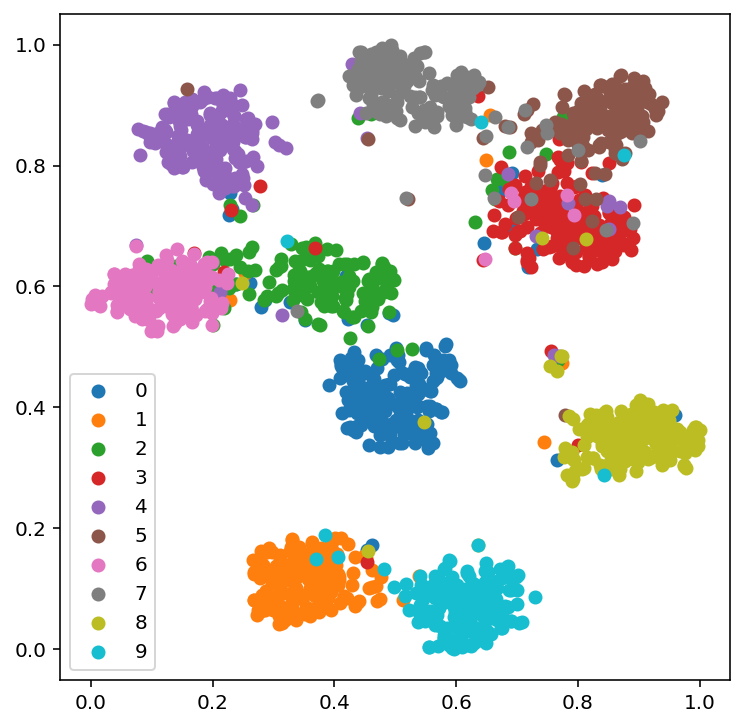

In [ ]:
from sklearn.manifold import TSNE


tsne = TSNE()
images_cpu = [im.cpu().numpy().flatten() for im in images_db]
labels_cpu = [l.cpu().numpy().argmax() for l in labels_db]
X_embedded = tsne.fit_transform(np.array(images_cpu), np.array(labels_cpu))

plot_db(X_embedded, labels_cpu)